# Behavioral Patterns

The behavioral patterns are guidelines suggested to create classes that allows to communicate objects to each other. The goal of the behavioral patterns is to make those interactions easier and more understandable.

The five creational patterns available are:
1. Chain of Responsability
2. Command
3. Iterator
4. Mediator
5. Memento
6. Observer
7. State
8. Strategy
9. Template method
10. Visitor

Again, we are going to be convering eaach of the possible patterns and making some examples in the context of machine learning engineering.

# State

**What is a state?**

This is design pattern that allows to modify an object behavior when an inner state has changed. 

**When should we use it?**

This is suitable when dealing with several `if/else` statements or we have create an finite states machine. It allows to reduce the complexity generated in `god objects` due to the excesive use of the `if/else` statements.

**Scenario**

You're a machine learning engineer creating an autoprocessing pipeline for data. The autoprocessing tool should be able to detect if the dataframe needs the following:

1. Label Encoding
2. MinMax scaling
3. Remove colinerarity
4. Remove no relevant features.

The finite state machine would look like:

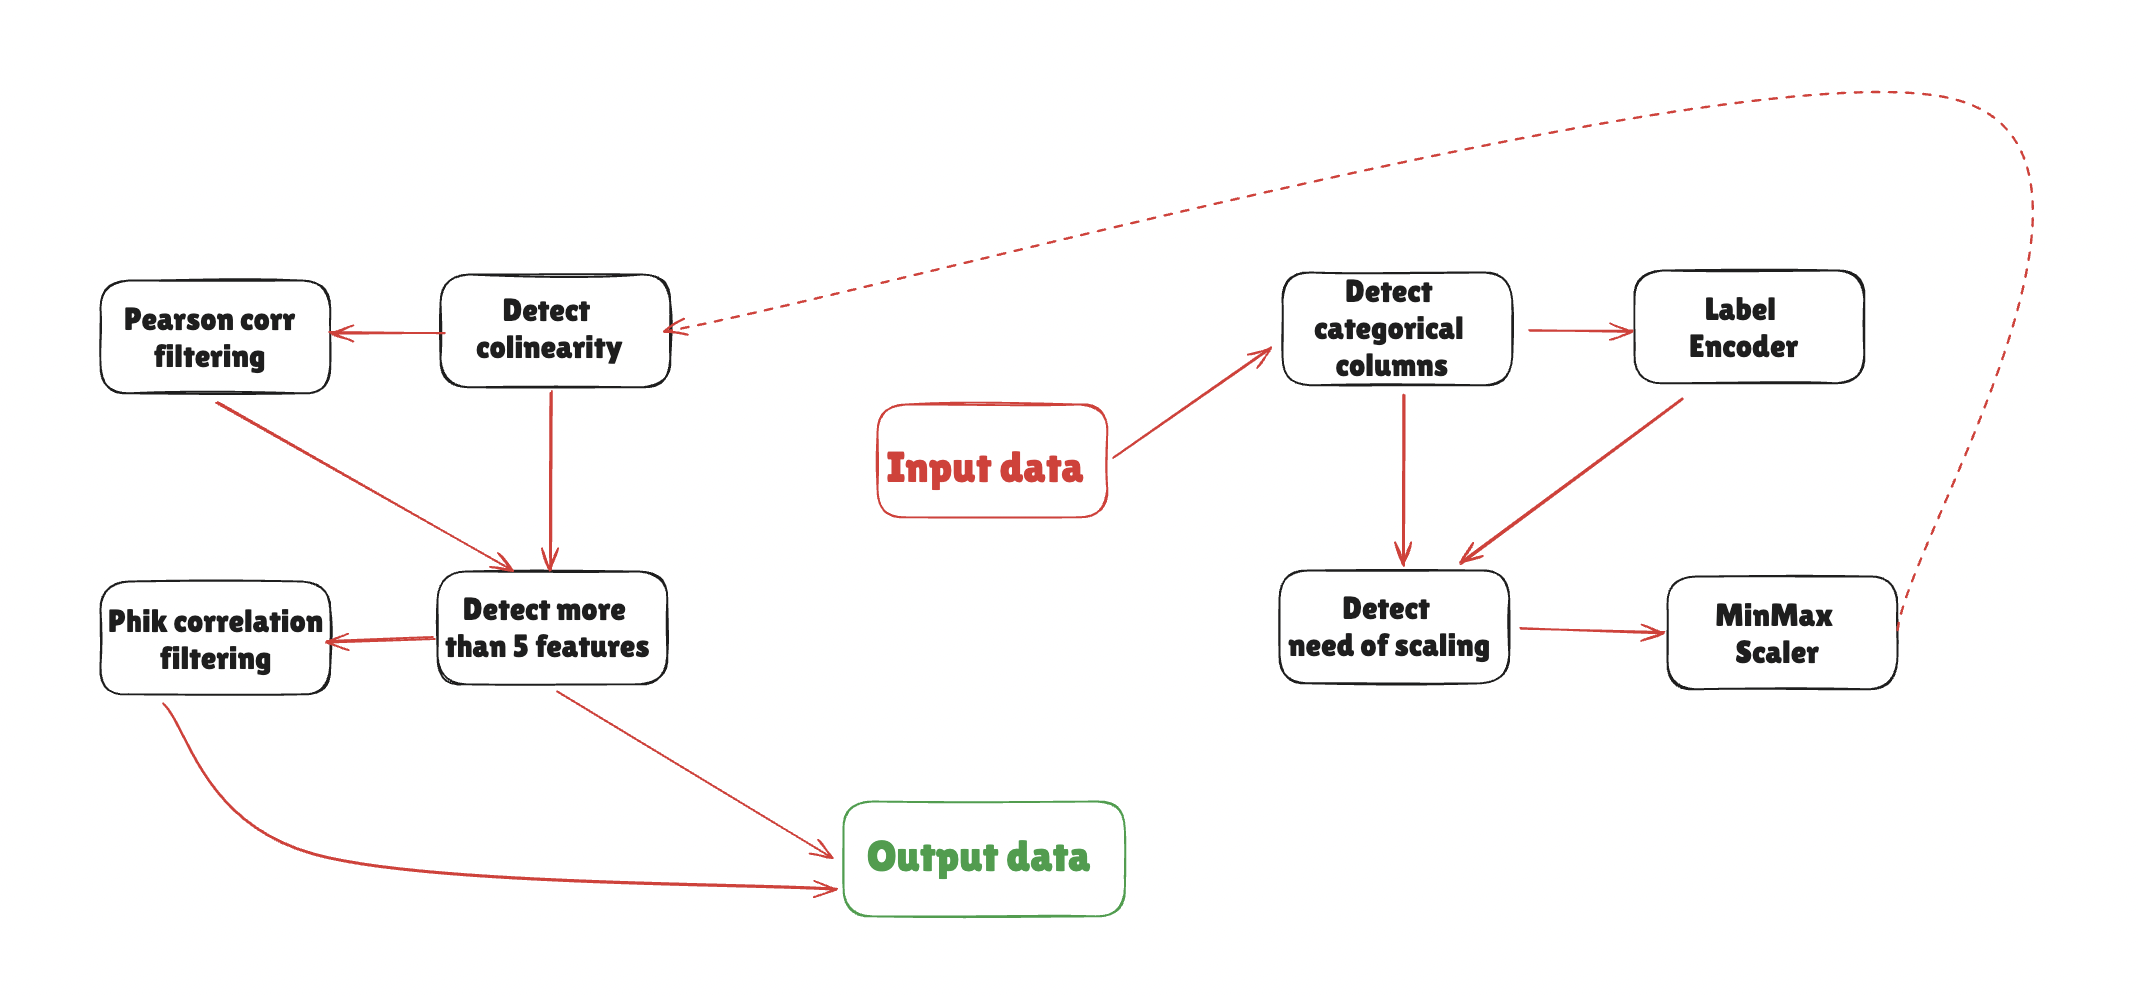

In [35]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from abc import ABC

import pandas as pd

In [36]:
df = load_diabetes(as_frame=True, return_X_y=True)

In [37]:
df = pd.concat([df[0], df[1]], axis=1)

## Antipattern

The easiest antipattern is to create a class that manages the transformations through `if/else` statements.

In [38]:
class AutoDataProcessor:
    def __init__(self):
        self.label_encoders = {}
        self.correlation_matrix = None

    def _detect_label_encoding_need(self, df: pd.DataFrame) -> tuple:
        cat_cols = df.select_dtypes(include=["object"]).columns
        if len(cat_cols) == 0:
            return False, None
        return True, list(cat_cols)

    def _transform_label_encoding(
        self, df: pd.DataFrame, cat_cols: list
    ) -> pd.DataFrame:
        le = LabelEncoder()
        for col in cat_cols:
            df[col] = le.fit_transform(df[col])
            self.label_encoders[col] = le
        return df

    def _detect_minmax_scaler_need(self, df: pd.DataFrame) -> bool:
        min = df.min(axis=1)
        max = df.max(axis=1)
        if (min < 0).any() or (max > 1).any():
            return True
        return False

    def _transform_minmax_scaler(self, df: pd.DataFrame) -> pd.DataFrame:
        scaler = MinMaxScaler()
        df[df.columns] = scaler.fit_transform(df[df.columns])
        return df

    def _detect_colinerarity(self, df: pd.DataFrame, target_col: str) -> tuple:
        self.correlation_matrix = df.corr()
        target_corr = self.correlation_matrix[target_col].abs()
        high_corr = target_corr[target_corr > 0.8].index.tolist()
        if len(high_corr) > 1:
            return True, high_corr
        return False, None

    def _transform_colinerarity(
        self, df: pd.DataFrame, cols_to_remove: list
    ) -> pd.DataFrame:
        df = df.drop([cols_to_remove], axis=1)
        return df

    def _detect_feature_selection(self, df: pd.DataFrame) -> bool:
        if df.shape[1] > 5:
            return True
        return False

    def _transform_feature_selection(
        self, df: pd.DataFrame, target_col: str
    ) -> pd.DataFrame:
        phik_matrix = df.phik_matrix()
        target_corr = phik_matrix[target_col].abs()
        top_features = target_corr.sort_values(ascending=False).index[1:6].tolist()
        return df[top_features + [target_col]]

    def transform(self, df: pd.DataFrame, target_col: str) -> pd.DataFrame:
        need_le, cat_cols = self._detect_label_encoding_need(df)
        if need_le:
            df = self._transform_label_encoding(df, cat_cols)

        need_scaler = self._detect_minmax_scaler_need(df)
        if need_scaler:
            df = self._transform_minmax_scaler(df)

        need_colinear, cols_to_remove = self._detect_colinerarity(df, target_col)
        if need_colinear:
            df = self._transform_colinerarity(df, cols_to_remove)

        need_feature_selection = self._detect_feature_selection(df)
        if need_feature_selection:
            df = self._transform_feature_selection(df, target_col)

        return df

Create the class for the autodata processor

In [39]:
data_processor = AutoDataProcessor()

Transform the data

In [40]:
result = data_processor.transform(df, target_col="target")

interval columns not set, guessing: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']


In [41]:
result

,bmi,s5,s4,bp,s3,target
0,0.582645,0.562217,0.282087,0.549296,0.207792,0.392523
1,0.148760,0.222437,0.141044,0.352113,0.623377,0.155763
2,0.516529,0.496578,0.282087,0.436620,0.246753,0.361371
3,0.301653,0.572923,0.423131,0.309859,0.233766,0.563863
4,0.206612,0.362385,0.282087,0.549296,0.389610,0.342679
...,...,...,...,...,...,...
437,0.421488,0.605672,0.282087,0.704225,0.259740,0.476636
438,0.285124,0.415810,0.423131,0.183099,0.259740,0.246106
439,0.285124,0.305030,0.249647,0.530563,0.272727,0.333333
440,0.495868,0.657026,0.393512,0.464789,0.259740,0.607477


What is the problem introduced in the previous class?

This is behaving like a `god object`. It depends on several `if/else` statements for the execution. It is highly likely if we modify a single piece of code, we can breake all our code. Thus, it breakes the single responsability principle because it does several actions at the same time. In addition, it breakes the open-closed principle.

**How to solve the antipattern?**

1. Create a single class for each operation which manages the operations `State class`.
2. Inside the new class, let's save what are gonna be the next state based on the results
3. Create a manager class that defines since which step launch our process `Manager class`. 

## Pattern

1. Create a footprint for any state class

In [42]:
class AutoProcessorState(ABC):
    def handle(self, context):
        pass

2. Define the classes for the label encoding detection and processing

In [43]:
class LabelEncodingDetectionState(AutoProcessorState):
    def _detect_label_encoding_need(self, df: pd.DataFrame) -> tuple:
        cat_cols = df.select_dtypes(include=["object"]).columns
        if len(cat_cols) == 0:
            return False, None
        return True, list(cat_cols)

    def handle(self, context):
        need_le, cat_cols = self._detect_label_encoding_need(context.df)
        if need_le:
            context.state = LabelEncodingTransformationState(cat_cols)
        else:
            context.state = MinMaxScalerDetectionState()


class LabelEncodingTransformationState(AutoProcessorState):
    def __init__(self, cat_cols):
        self.cat_cols = cat_cols

    def _transform_label_encoding(self, df: pd.DataFrame) -> pd.DataFrame:
        le = LabelEncoder()
        for col in self.cat_cols:
            df[col] = le.fit_transform(df[col])
            self.label_encoders[col] = le
        return df

    def handle(self, context):
        result = self._transform_label_encoding(context.df)
        context.df = result
        context.state = MinMaxScalerDetectionState()

3. Define the MinMaxScaler detector and processor

In [44]:
class MinMaxScalerDetectionState(AutoProcessorState):
    def _detect_minmax_scaler_need(self, df: pd.DataFrame) -> bool:
        min = df.min(axis=1)
        max = df.max(axis=1)
        if (min < 0).any() or (max > 1).any():
            return True
        return False

    def handle(self, context):
        need_scaler = self._detect_minmax_scaler_need(context.df)
        if need_scaler:
            context.state = MinMaxScalerTransformationState()
        else:
            context.state = ColinearityDetectionState()


class MinMaxScalerTransformationState(AutoProcessorState):
    def _transform_minmax_scaler(self, df: pd.DataFrame) -> pd.DataFrame:
        scaler = MinMaxScaler()
        df[df.columns] = scaler.fit_transform(df[df.columns])
        return df

    def handle(self, context):
        result = self._transform_minmax_scaler(context.df)
        context.df = result
        context.state = ColinearityDetectionState()

4. Define the Multicolinearity detection state and transformer

In [45]:
class ColinearityDetectionState(AutoProcessorState):
    def _detect_colinerarity(self, df: pd.DataFrame, target_col: str) -> tuple:
        self.correlation_matrix = df.corr()
        target_corr = self.correlation_matrix[target_col].abs()
        high_corr = target_corr[target_corr > 0.8].index.tolist()
        if len(high_corr) > 1:
            return True, high_corr
        return False, None

    def handle(self, context):
        need_colinear, cols_to_remove = self._detect_colinerarity(
            context.df, context.target_col
        )
        if need_colinear:
            context.state = ColinearityTransformationState(cols_to_remove)
        else:
            context.state = FeatureSelectionDetectionState()


class ColinearityTransformationState(AutoProcessorState):
    def __init__(self, cols_to_remove):
        self.cols_to_remove = cols_to_remove

    def _transform_colinerarity(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.drop([self.cols_to_remove], axis=1)
        return df

    def handle(self, context):
        result = self._transform_colinerarity(context.df)
        context.df = result
        context.state = FeatureSelectionDetectionState()

5. Define the classes for the Feature selection

In [46]:
class FeatureSelectionDetectionState(AutoProcessorState):
    def _detect_feature_selection(self, df: pd.DataFrame) -> bool:
        if df.shape[1] > 5:
            return True
        return False

    def handle(self, context):
        need_feature_selection = self._detect_feature_selection(context.df)
        if need_feature_selection:
            context.state = FeatureSelectionTransformationState(context.target_col)
        else:
            context.state = None


class FeatureSelectionTransformationState(AutoProcessorState):
    def __init__(self, target_col):
        self.target_col = target_col

    def _transform_feature_selection(self, df: pd.DataFrame) -> pd.DataFrame:
        phik_matrix = df.phik_matrix()
        target_corr = phik_matrix[self.target_col].abs()
        top_features = target_corr.sort_values(ascending=False).index[1:6].tolist()
        return df[top_features + [self.target_col]]

    def handle(self, context):
        result = self._transform_feature_selection(context.df)
        context.df = result
        context.state = None

6. Define the manager class

In [47]:
class AutoProcessorStateManager:
    def __init__(self, df: pd.DataFrame, target_col: str):
        self.df = df
        self.target_col = target_col
        self.state = LabelEncodingDetectionState()

    def process(self):
        while self.state is not None:
            self.state.handle(self)
        return self.df

Create a client with the new autoprocessor

In [48]:
new_data_processor = AutoProcessorStateManager(df, target_col="target")

Process the data

In [49]:
result2 = new_data_processor.process()

interval columns not set, guessing: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'target']


In [50]:
result2

,bmi,s5,s4,bp,s3,target
0,0.582645,0.562217,0.282087,0.549296,0.207792,0.392523
1,0.148760,0.222437,0.141044,0.352113,0.623377,0.155763
2,0.516529,0.496578,0.282087,0.436620,0.246753,0.361371
3,0.301653,0.572923,0.423131,0.309859,0.233766,0.563863
4,0.206612,0.362385,0.282087,0.549296,0.389610,0.342679
...,...,...,...,...,...,...
437,0.421488,0.605672,0.282087,0.704225,0.259740,0.476636
438,0.285124,0.415810,0.423131,0.183099,0.259740,0.246106
439,0.285124,0.305030,0.249647,0.530563,0.272727,0.333333
440,0.495868,0.657026,0.393512,0.464789,0.259740,0.607477


As you see before, the new classes created allows to create any kind of data flow. It does not matter how many additional steps or process we want to include. In addition, it does not breake the single resposability development principle and the open-closed principle. In addition, it allows to follow the interface segregation principle.